In [2]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import math
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data_path = '../data/hcvdat0.csv'
df = pd.read_csv(data_path, index_col=0)
df[['Category', 'Category_name']] = df.apply(lambda x: x.Category.split('='), axis=1, result_type='expand')
df.head()

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,Category_name
1,0,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0,Blood Donor
2,0,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5,Blood Donor
3,0,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3,Blood Donor
4,0,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7,Blood Donor
5,0,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7,Blood Donor


In [4]:
numerical_columns = set(df.columns) - {'Category', 'Sex', 'Category_name'}
df_eda = df[list(numerical_columns)]
df_eda.head()

,Age,CHE,BIL,PROT,ALP,CHOL,ALB,CREA,GGT,AST,ALT
1,32,6.93,7.5,69.0,52.5,3.23,38.5,106.0,12.1,22.1,7.7
2,32,11.17,3.9,76.5,70.3,4.80,38.5,74.0,15.6,24.7,18.0
3,32,8.84,6.1,79.3,74.7,5.20,46.9,86.0,33.2,52.6,36.2
4,32,7.33,18.9,75.7,52.0,4.74,43.2,80.0,33.8,22.6,30.6
5,32,9.15,9.6,68.7,74.1,4.32,39.2,76.0,29.9,24.8,32.6


In [5]:
df_params = pd.DataFrame(columns=['min', 'max', 'mean', 'median', 'std'])
df_params[['min', 'max', 'mean', 'median', 'std']] = df_eda.apply(
    lambda x: (x.min(), x.max(), x.mean(), x.median(), x.std()),
    result_type='expand'
).transpose()
df_params

,min,max,mean,median,std
Age,19.00,77.00,47.408130,47.00,10.055105
CHE,1.42,16.41,8.196634,8.26,2.205657
BIL,0.80,254.00,11.396748,7.30,19.673150
PROT,44.80,90.00,72.044137,72.20,5.402636
ALP,11.30,416.60,68.283920,66.20,26.028315
CHOL,1.43,9.67,5.368099,5.30,1.132728
ALB,14.90,82.20,41.620195,41.95,5.780629
CREA,8.00,1079.10,81.287805,77.00,49.756166
GGT,4.50,650.90,39.533171,23.30,54.661071
AST,10.60,324.00,34.786341,25.90,33.090690


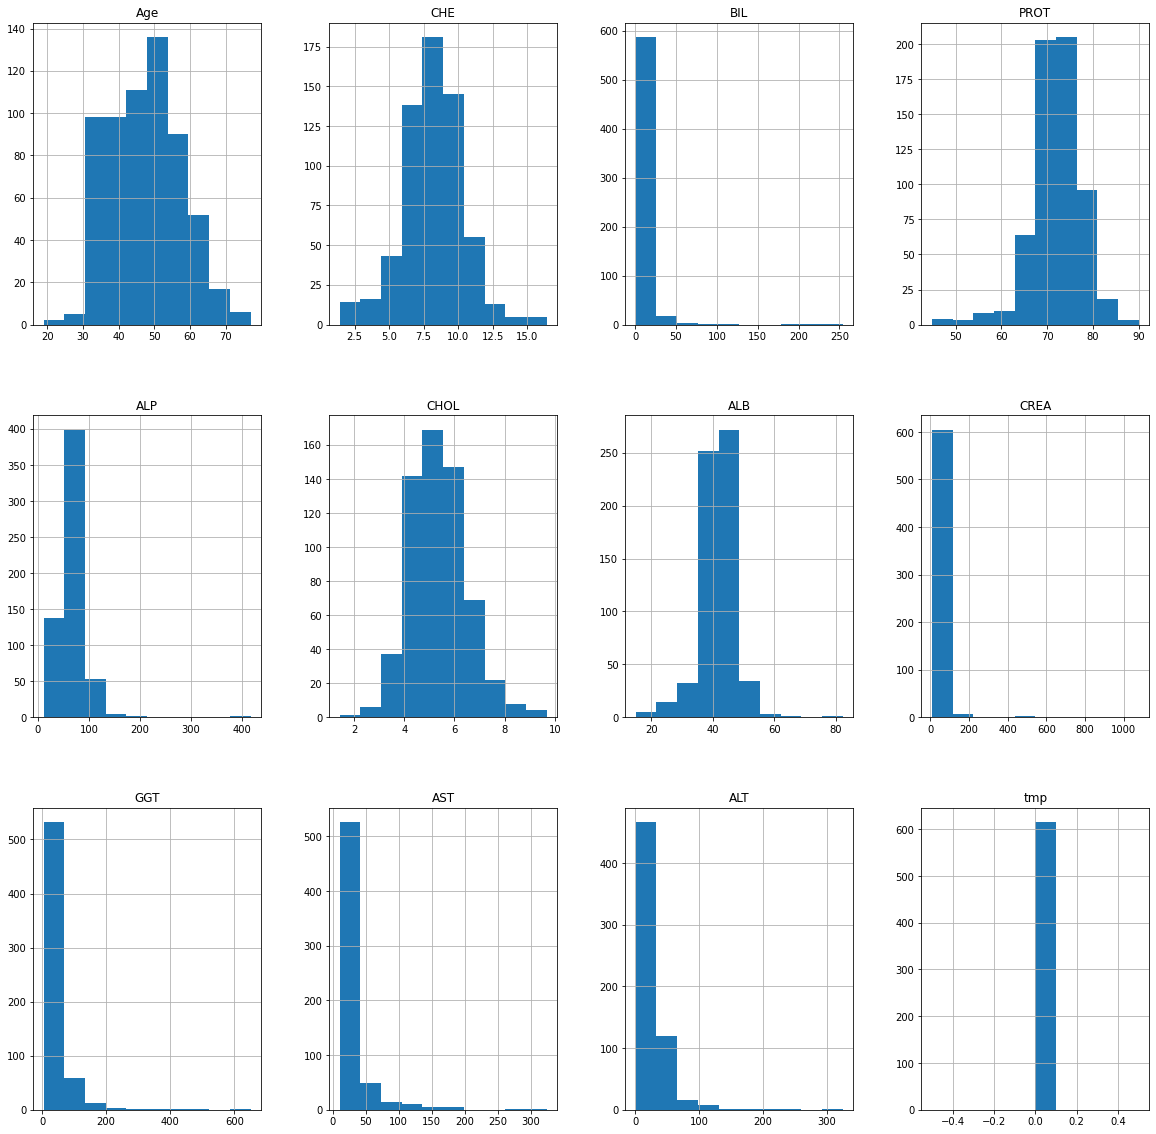

In [6]:
df_tmp = df_eda.copy()
df_tmp['tmp'] = 0.0
fig, axis = plt.subplots(3, 4,figsize=(20, 20))
fig = df_tmp.hist(ax=axis)

In [7]:
normal_columns = ('Age', 'CHOL', 'ALB', 'CHE', 'PROT')
long_tail_columns = tuple(set(df_eda.columns) - set(normal_columns))
long_tail_columns

('BIL', 'ALP', 'CREA', 'GGT', 'AST', 'ALT')

In [8]:
def fuzzy_normal_feature(params, feature):
    mean, std = params[['mean', 'std']].loc[feature]
    std /= 2
    dist = norm(loc=mean, scale=std)
    distmax = dist.pdf(mean)
    mid = lambda x: dist.pdf(x)/distmax
    low = lambda x: 1. - mid([val if val < mean else mean for val in x]) 
    high = lambda x: 1. - mid([val if val > mean else mean for val in x]) 
    return low, mid, high

def fuzzy_long_feature(params, feature):
    median, std = params[['median', 'std']].loc[feature]
    std = math.sqrt(std)
    dist = norm(loc=median, scale=std)
    distmax = dist.pdf(median)
    mid = lambda x: dist.pdf(x)/distmax
    low = lambda x: 1. - mid([val if val < median else median for val in x]) 
    high = lambda x: 1. - mid([val if val > median else median for val in x]) 
    return low, mid, high

In [9]:
low, mid, high = fuzzy_normal_feature(df_params, 'Age')

In [10]:
def fuzzyfication(params, feature, type_='normal'):
    if type_ == 'normal':
        return fuzzy_normal_feature(params, feature)
    return fuzzy_long_feature(params, feature)

def plot_fuzzyfication(df_values, df_params,feature, type_='normal'):
    low, mid, high = fuzzyfication(df_params, feature, type_)
    base_values = df_values[feature].sort_values()
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(
        go.Scatter(
            x=base_values,
            y=low(base_values),
            name='low'
        )
    )
    fig.add_trace(
        go.Scatter(
            x=base_values,
            y=mid(base_values),
            name='mid'
        )
    )
    fig.add_trace(
        go.Scatter(
            x=base_values,
            y=high(base_values),
            name='high'
        )
    )
    fig.add_trace(
        go.Histogram(
            x=base_values,
            name='distribution',
            opacity=0.3,
            marker=dict(
                color='orange',
            )
        ),
        secondary_y=True,
    )
    fig.show()

In [12]:
plot_fuzzyfication(df_eda, df_params, 'CHOL', type_='normal')